In [18]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm
from zipfile import ZipFile
import os

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

## Load Data

In [26]:
base_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/'

# possible datasets
datasets = ['F-F_Research_Data_Factors_CSV.zip',
            '30_Industry_Portfolios_CSV.zip']

# first we download the data, then we read it, then we delete the folders
for dataset in tqdm(datasets):
    # download the data
    url = base_url + dataset
    r = requests.get(url, allow_redirects=True)
    open(dataset, 'wb').write(r.content)
    # read the data
    with ZipFile(dataset, 'r') as zipObj:
        # Extract all the contents of zip file in current directory
        zipObj.extractall()

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:37<00:00, 18.86s/it]


Create a DataFrame of the 30 Industries Portfolios

In [27]:
with open('30_Industry_Portfolios.CSV') as f:
    for i, line in enumerate(f):
        if line.startswith(','):
            start_ = i
            break
    for j, line in enumerate(f):
        if line == '\n' and j > start_:
            end_ = j
            break

# read the data from start_ to end_
ind_df = pd.read_csv('30_Industry_Portfolios.CSV', skiprows=start_, nrows=end_-start_)
# rename the first column to date and make it the index
ind_df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# the year is the first four digits month the last two, make a date
ind_df['date'] = pd.to_datetime(ind_df['date'].astype(str).str[:4] + '-' + ind_df['date'].astype(str).str[-2:])
# move each date to the last day of the month
ind_df['date'] = ind_df['date'] + pd.offsets.MonthEnd(0)

# make date the index
ind_df.set_index('date', inplace=True)

# we dont need the data anymore, so we delete the folder
os.remove('30_Industry_Portfolios.CSV')
os.remove('30_Industry_Portfolios_CSV.zip')

ind_df

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.56,-5.19,1.29,2.93,10.97,-0.48,8.08,1.77,8.14,0.39,...,0.83,9.22,2.06,7.70,1.91,-23.79,0.07,1.87,-0.02,5.20
1926-08-31,2.59,27.03,6.50,0.55,10.01,-3.58,-2.51,4.25,5.50,7.97,...,2.17,2.02,4.39,-2.38,4.85,5.39,-0.75,-0.13,4.47,6.76
1926-09-30,1.16,4.02,1.26,6.58,-0.99,0.73,-0.51,0.69,5.33,2.30,...,2.41,2.25,0.19,-5.54,0.07,-7.87,0.25,-0.56,-1.61,-3.86
1926-10-31,-3.06,-3.31,1.06,-4.76,9.47,-4.68,0.12,-0.57,-4.76,1.00,...,-0.11,-2.00,-1.09,-5.08,-2.61,-15.38,-2.20,-4.11,-5.51,-8.49
1926-11-30,6.35,7.29,4.55,1.66,-5.80,-0.54,1.87,5.42,5.20,3.10,...,1.63,3.77,3.64,3.84,1.61,4.67,6.52,4.33,2.34,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,1.42,-5.36,-0.80,-1.63,3.56,-4.34,-5.70,-1.01,-2.63,-7.25,...,0.23,-6.76,-2.82,-6.17,0.17,1.57,-1.79,-1.19,-1.70,1.34
2022-03-31,1.03,3.34,-2.25,-4.78,0.86,-3.25,-1.12,5.13,2.98,-9.03,...,-2.46,2.65,4.27,0.13,4.07,3.11,3.35,0.85,-0.99,7.80
2022-04-30,3.01,3.03,6.37,-25.22,-10.76,2.04,-7.00,-6.80,-2.28,6.63,...,-10.70,-12.59,-12.26,-0.74,-10.93,-2.14,-11.41,-5.47,-7.99,-7.65


Create a DataFrame of Fama-French Factors

In [28]:
with open('F-F_Research_Data_Factors.CSV') as f:
    for i, line in enumerate(f):
        if line.startswith(','):
            start_ = i
            break
    for j, line in enumerate(f):
        if line == '\n' and j > start_:
            end_ = j
            break

# read the data from start_ to end_
ff_df = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows=start_, nrows=end_-start_)
# rename the first column to date and make it the index
ff_df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# the year is the first four digits month the last two, make a date
ff_df['date'] = pd.to_datetime(ff_df['date'].astype(str).str[:4] + '-' + ff_df['date'].astype(str).str[-2:])
# move each date to the last day of the month
ff_df['date'] = ff_df['date'] + pd.offsets.MonthEnd(0)

# make date the index
ff_df.set_index('date', inplace=True)

# we dont need the data anymore, so we delete the folder
os.remove('F-F_Research_Data_Factors.CSV')
os.remove('F-F_Research_Data_Factors_CSV.zip')
ff_df

,Mkt-RF,SMB,HML,RF
date,,,,
1926-07-31,2.96,-2.56,-2.43,0.22
1926-08-31,2.64,-1.17,3.82,0.25
1926-09-30,0.36,-1.40,0.13,0.23
1926-10-31,-3.24,-0.09,0.70,0.32
1926-11-30,2.53,-0.10,-0.51,0.31
...,...,...,...,...
2022-10-31,7.83,0.09,8.05,0.23
2022-11-30,4.60,-3.40,1.38,0.29
2022-12-31,-6.41,-0.68,1.32,0.33


In [29]:
# keep only the Mkt-RF and RFcolumn
ff_df = ff_df[['Mkt-RF', 'RF']]
ff_df

,Mkt-RF,RF
date,,
1926-07-31,2.96,0.22
1926-08-31,2.64,0.25
1926-09-30,0.36,0.23
1926-10-31,-3.24,0.32
1926-11-30,2.53,0.31
...,...,...
2022-10-31,7.83,0.23
2022-11-30,4.60,0.29
2022-12-31,-6.41,0.33


In [30]:
# merge the two dataframes on the index
df = ind_df.merge(ff_df, left_index=True, right_index=True)
df

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other,Mkt-RF,RF
date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.56,-5.19,1.29,2.93,10.97,-0.48,8.08,1.77,8.14,0.39,...,2.06,7.70,1.91,-23.79,0.07,1.87,-0.02,5.20,2.96,0.22
1926-08-31,2.59,27.03,6.50,0.55,10.01,-3.58,-2.51,4.25,5.50,7.97,...,4.39,-2.38,4.85,5.39,-0.75,-0.13,4.47,6.76,2.64,0.25
1926-09-30,1.16,4.02,1.26,6.58,-0.99,0.73,-0.51,0.69,5.33,2.30,...,0.19,-5.54,0.07,-7.87,0.25,-0.56,-1.61,-3.86,0.36,0.23
1926-10-31,-3.06,-3.31,1.06,-4.76,9.47,-4.68,0.12,-0.57,-4.76,1.00,...,-1.09,-5.08,-2.61,-15.38,-2.20,-4.11,-5.51,-8.49,-3.24,0.32
1926-11-30,6.35,7.29,4.55,1.66,-5.80,-0.54,1.87,5.42,5.20,3.10,...,3.64,3.84,1.61,4.67,6.52,4.33,2.34,4.00,2.53,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,1.42,-5.36,-0.80,-1.63,3.56,-4.34,-5.70,-1.01,-2.63,-7.25,...,-2.82,-6.17,0.17,1.57,-1.79,-1.19,-1.70,1.34,-2.29,0.00
2022-03-31,1.03,3.34,-2.25,-4.78,0.86,-3.25,-1.12,5.13,2.98,-9.03,...,4.27,0.13,4.07,3.11,3.35,0.85,-0.99,7.80,3.05,0.01
2022-04-30,3.01,3.03,6.37,-25.22,-10.76,2.04,-7.00,-6.80,-2.28,6.63,...,-12.26,-0.74,-10.93,-2.14,-11.41,-5.47,-7.99,-7.65,-9.46,0.01


In [31]:
df.replace(-99.99, np.nan, inplace=True)
df.replace(-999, np.nan, inplace=True)

# make all returns by dividing by 100
df = df/100
df

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other,Mkt-RF,RF
date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0206,0.0770,0.0191,-0.2379,0.0007,0.0187,-0.0002,0.0520,0.0296,0.0022
1926-08-31,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0797,...,0.0439,-0.0238,0.0485,0.0539,-0.0075,-0.0013,0.0447,0.0676,0.0264,0.0025
1926-09-30,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0230,...,0.0019,-0.0554,0.0007,-0.0787,0.0025,-0.0056,-0.0161,-0.0386,0.0036,0.0023
1926-10-31,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0109,-0.0508,-0.0261,-0.1538,-0.0220,-0.0411,-0.0551,-0.0849,-0.0324,0.0032
1926-11-30,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0310,...,0.0364,0.0384,0.0161,0.0467,0.0652,0.0433,0.0234,0.0400,0.0253,0.0031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,0.0142,-0.0536,-0.0080,-0.0163,0.0356,-0.0434,-0.0570,-0.0101,-0.0263,-0.0725,...,-0.0282,-0.0617,0.0017,0.0157,-0.0179,-0.0119,-0.0170,0.0134,-0.0229,0.0000
2022-03-31,0.0103,0.0334,-0.0225,-0.0478,0.0086,-0.0325,-0.0112,0.0513,0.0298,-0.0903,...,0.0427,0.0013,0.0407,0.0311,0.0335,0.0085,-0.0099,0.0780,0.0305,0.0001
2022-04-30,0.0301,0.0303,0.0637,-0.2522,-0.1076,0.0204,-0.0700,-0.0680,-0.0228,0.0663,...,-0.1226,-0.0074,-0.1093,-0.0214,-0.1141,-0.0547,-0.0799,-0.0765,-0.0946,0.0001


Calculate CAPM return series

In [32]:
betas = np.zeros(len(df.columns))
var_market = np.var(df['Mkt-RF'])
for i, ind in tqdm(enumerate(df.columns)):
    # compute betas
    betas[i] = np.cov(df[ind], df['Mkt-RF'])[0,1]/var_market

# make betas a series with the column names as index
betas = pd.Series(betas, index=df.columns)

# compute the sample mean of returns
# we annualize
mean_returns = df.mean()*100*12

# compute the implied expected returns by the CAPM
capm_returns = np.zeros(len(df.columns))
for i, ind in tqdm(enumerate(df.columns)):
    # compute the implied expected returns by the CAPM
    capm_returns[i] = mean_returns['RF'] + betas[i]*(mean_returns['Mkt-RF'])

# make capm_returns a series with the column names as index
capm_returns = pd.Series(capm_returns, index=df.columns)
capm_returns

32it [00:00, 4036.02it/s]
32it [00:00, ?it/s]


Food       9.040514
Beer      10.607695
Smoke      8.197363
Games     14.305793
Books     12.095989
Hshld     10.297232
Clths      9.843760
Hlth       9.882916
Chems     11.567746
Txtls     12.378786
Cnstr     12.652046
Steel     14.100954
FabPr     13.130308
ElcEq     13.509809
Autos     13.477306
Carry     12.739042
Mines     10.531427
Coal      13.485596
Oil       10.324349
Util       9.316884
Telcm      8.528292
Servs      9.790965
BusEq     11.839916
Paper     10.798177
Trans     12.326059
Whlsl     11.910919
Rtail     10.934025
Meals     10.776112
Fin       12.496724
Other     11.656893
Mkt-RF    11.234163
RF         3.172908
dtype: float64

Plot the SML

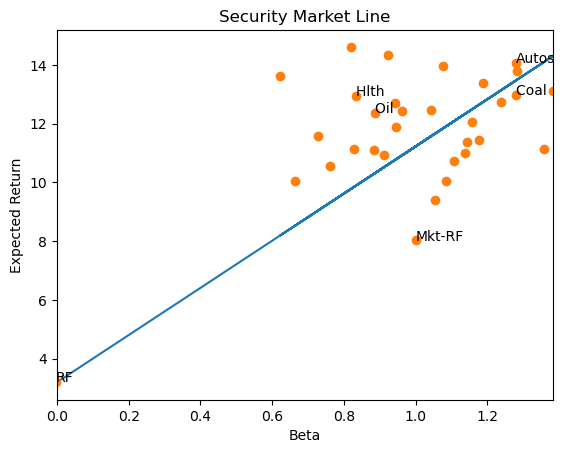

In [33]:
# plot the security market line and label axis
plt.plot(betas, capm_returns, '-')
plt.plot(betas, mean_returns, 'o')
# x axist starts at 0
plt.xlim(0, max(betas))
# label the Mkt-RF point and 5 random other points
plt.text(betas['Mkt-RF'], mean_returns['Mkt-RF'], 'Mkt-RF')
for i in np.random.randint(1, len(df.columns), 5):
    plt.text(betas[i], mean_returns[i], df.columns[i])
plt.xlabel('Beta')
plt.ylabel('Expected Return')
plt.title('Security Market Line')
plt.show()

In [34]:
w = 60 # window size
# we create a dataframe with the betas
betas_df = pd.DataFrame(index=df.index, columns=df.columns)
sd_df = pd.DataFrame(index=df.index, columns=df.columns)
# compute beta using data from t-w-1 to t-1 assign this beta to t
# dont use the var_market computed before, as it is not a rolling window
for t in tqdm(range(w, len(df))):
    # compute the betas for each industry
    for i, ind in enumerate(df.columns):
        # compute betas
        betas_df.iloc[t, i] = np.cov(df.iloc[t-w:t, i], df.iloc[t-w:t, -2])[0,1]/np.var(df.iloc[t-w:t, -2])
        # compute the standard error of returns
        sd_df.iloc[t,i] = np.std(df.iloc[t-w:t, i] - betas_df.iloc[t, i]*df.iloc[t-w:t, -2])
print(betas_df)
print(sd_df)

100%|██████████████████████████████████████████████████████████████████████████████| 1092/1092 [00:37<00:00, 29.48it/s]

               Food      Beer      Smoke     Games     Books     Hshld  \
date                                                                     
1926-07-31       NaN       NaN       NaN       NaN       NaN       NaN   
1926-08-31       NaN       NaN       NaN       NaN       NaN       NaN   
1926-09-30       NaN       NaN       NaN       NaN       NaN       NaN   
1926-10-31       NaN       NaN       NaN       NaN       NaN       NaN   
1926-11-30       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-02-28  0.647039  0.683425   0.65034  1.261591  1.206473  0.651481   
2022-03-31  0.640121  0.687592  0.636843  1.264087  1.194195  0.656132   
2022-04-30  0.639372  0.689865  0.632829  1.257281  1.191091  0.648042   
2022-05-31  0.573093  0.620848  0.539114  1.353915  1.183552  0.590318   
2022-06-30  0.574679  0.622428  0.536137  1.355585  1.189708  0.595485   

               Clths     Hlth      Ch

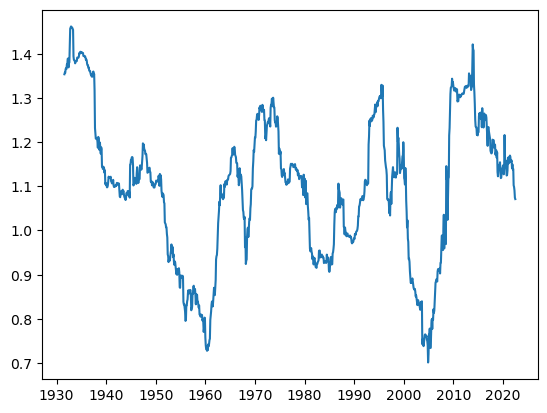

In [11]:
# plot the betas for the finance industry
plt.plot(betas_df['Fin  '])

In [12]:
# we now do a series of cross sectional regressions
# of the model 
# r = gamma_0 + gamma_1 beta + gamma_2 beta^2 + gamma_3 std
# we use the betas and standard deviations computed above

gamma_0 = np.zeros(len(df))
gamma_1 = np.zeros(len(df))
gamma_2 = np.zeros(len(df))
gamma_3 = np.zeros(len(df))

#betas_df = betas_df[[c for c in betas_df.columns if c!='Mkt-RF']]
#sd_df = sd_df[[c for c in sd_df.columns if c!='Mkt-RF']]

for t in tqdm(range(w, len(df))):

    X = np.vstack([betas_df.iloc[t], betas_df.iloc[t]**2, sd_df.iloc[t]]).T
    y = df.iloc[t].values
    # convert X to float, makes missing values NaNs
    X = X.astype(float)
    # we use the OLS function from statsmodels
    # we use the constant term
    model = sm.OLS(y, sm.add_constant(X))
    results = model.fit()
    # obtain the coefficients
    gamma_0[t] = results.params[0]
    gamma_1[t] = results.params[1]
    gamma_2[t] = results.params[2]
    gamma_3[t] = results.params[3]

# do a t test to see if gamma_0 equals mean_returns['RF']
# we use the t test from statsmodels

t_0 = (gamma_0[w:].mean() - mean_returns['RF'])/(gamma_0[w:].std()/np.sqrt(len(gamma_0[w:])))
t_1 = (gamma_1[w:].mean()- mean_returns['Mkt-RF'])/(gamma_1[w:].std()/np.sqrt(len(gamma_1[w:])))
# t_2 and t_3 have zero on the RHS
t_2 = gamma_2[w:].mean()/(gamma_2[w:].std()/np.sqrt(len(gamma_2[w:])))
t_3 = gamma_3[w:].mean()/(gamma_3[w:].std()/np.sqrt(len(gamma_3[w:])))

100%|████████████████████████████████████████████████████████████████████████████| 1092/1092 [00:00<00:00, 1415.80it/s]


In [13]:
# do a t test to see if gamma_0 equals mean_returns['RF']
# we use the t test from statsmodels

t_0 = (gamma_0[w:].mean() - mean_returns['RF'])/(gamma_0[w:].std()/np.sqrt(len(gamma_0[w:])))
t_1 = (gamma_1[w:].mean()- mean_returns['Mkt-RF'])/(gamma_1[w:].std()/np.sqrt(len(gamma_1[w:])))
# t_2 and t_3 have zero on the RHS
t_2 = gamma_2[w:].mean()/(gamma_2[w:].std()/np.sqrt(len(gamma_2[w:])))
t_3 = gamma_3[w:].mean()/(gamma_3[w:].std()/np.sqrt(len(gamma_3[w:])))

In [14]:
import scipy.stats as stats
# compute the p-value of each t test and print the test results
p_0 = 2*(1 - stats.t.cdf(abs(t_0), len(gamma_0[w:])))
p_1 = 2*(1 - stats.t.cdf(abs(t_1), len(gamma_1[w:])))
p_2 = 2*(1 - stats.t.cdf(abs(t_2), len(gamma_2[w:])))
p_3 = 2*(1 - stats.t.cdf(abs(t_3), len(gamma_3[w:])))
# print and round to 2 decimals
print('t_0 = {:.2f}, p_0 = {:.2f}'.format(t_0, p_0))
print('t_1 = {:.2f}, p_1 = {:.2f}'.format(t_1, p_1))
print('t_2 = {:.2f}, p_2 = {:.2f}'.format(t_2, p_2))
print('t_3 = {:.2f}, p_3 = {:.2f}'.format(t_3, p_3))

t_0 = -5565.66, p_0 = 0.00
t_1 = -2994.02, p_1 = 0.00
t_2 = -3.52, p_2 = 0.00
t_3 = 2.53, p_3 = 0.01


In [15]:
# estimate the alphas of the 30 portfolios with respect to the CAPM
alphas = np.zeros(len(df.columns))
# empty matrix to store the residuals
residuals = np.zeros((len(df), len(df.columns)))
for i, ind in enumerate(df.columns):
    alphas[i] = (df.loc[:, ind]-df.loc[:, 'RF']).mean() - betas[ind]*df.loc[:, 'Mkt-RF'].mean()
    residuals[:, i] = (df.loc[:, ind]-df.loc[:, 'RF']) - betas[ind]*df.loc[:, 'Mkt-RF']

# %%
# Covariance matrix of all portfolios
Sigma = np.cov(residuals.T)
# create GRS test
T = len(df)
N = len(df.columns) # note that we add 2 extra assets to the test
# sharpe ratio of the market
sharpe_mkt = (df.loc[:, 'Mkt-RF'].mean())/df.loc[:, 'Mkt-RF'].std()

# compute the GRS statistic, the F test
grs = (T*(T-N-1)/((T-2)*N))*alphas.T @ np.linalg.inv(Sigma) @ alphas /(1+sharpe_mkt**2)

# the grs follows a F with N, T-N-1 degrees of freedome
# compute the p-value
p_grs = 1 - stats.f.cdf(grs, N, T-N-1)

In [16]:
p_grs

1.1102230246251565e-16